In [3]:
import json 
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pandas.io.json
import seaborn as sns
pd.plotting.register_matplotlib_converters() 
%matplotlib inline

# Import weather_history_bulk JSON file
f = open("weather_history_bulk.json")
weather_history_bulk = json.load(f)

In [1]:
# Convert JSON file to DataFrame
df = pd.json_normalize(weather_history_bulk)

NameError: name 'pd' is not defined

In [3]:
# Data exploration
df.head

<bound method NDFrame.head of                  dt                         dt_iso  timezone  \
0         283996800  1979-01-01 00:00:00 +0000 UTC      3600   
1         284000400  1979-01-01 01:00:00 +0000 UTC      3600   
2         284004000  1979-01-01 02:00:00 +0000 UTC      3600   
3         284007600  1979-01-01 03:00:00 +0000 UTC      3600   
4         284011200  1979-01-01 04:00:00 +0000 UTC      3600   
...             ...                            ...       ...   
1972435  1704135600  2024-01-01 19:00:00 +0000 UTC    -28800   
1972436  1704139200  2024-01-01 20:00:00 +0000 UTC    -28800   
1972437  1704142800  2024-01-01 21:00:00 +0000 UTC    -28800   
1972438  1704146400  2024-01-01 22:00:00 +0000 UTC    -28800   
1972439  1704150000  2024-01-01 23:00:00 +0000 UTC    -28800   

                                                   weather  visibility  \
0        [{'id': 801, 'main': 'Clouds', 'description': ...     10000.0   
1        [{'id': 800, 'main': 'Clear', 'description':

In [4]:
df.shape 

(1972440, 23)

In [5]:
df.columns

Index(['dt', 'dt_iso', 'timezone', 'weather', 'visibility', 'lon', 'city_name',
       'lat', 'main.temp', 'main.temp_min', 'main.temp_max', 'main.feels_like',
       'main.pressure', 'main.humidity', 'main.dew_point', 'clouds.all',
       'wind.speed', 'wind.deg', 'snow.1h', 'wind.gust', 'rain.1h', 'rain.3h',
       'snow.3h'],
      dtype='object')

In [6]:
# Create seperate DataFrames by location
weather_history_berlin  = df.loc[df['city_name'] == 'Berlin']
weather_history_tulum  = df.loc[df['city_name'] == 'Tulum']
weather_history_corcovado  = df.loc[df['city_name'] == 'Parque Nacional Corcovado']
weather_history_kotao  = df.loc[df['city_name'] == 'Ko Tao']
weather_history_sandiego  = df.loc[df['city_name'] == 'San Diego']

In [9]:
pd.set_option('mode.chained_assignment', None)

def to_datetime(df, timestamp_column, date_column):
    df.loc[:, date_column] = pd.to_datetime(df.loc[:, timestamp_column], unit='s')
    df.drop(columns=[timestamp_column], inplace=True)
    df.loc[:, 'Y'] = df.loc[:, date_column].dt.year
    df.loc[:,'YM'] = df.loc[:, date_column].dt.to_period('M')

city_dfs = [weather_history_berlin, weather_history_tulum, weather_history_corcovado, weather_history_kotao, weather_history_sandiego]

for df in city_dfs:
    to_datetime(df, 'dt', 'date_column')


'''from datetime import datetime

def to_datetime(df, timestamp_column, date):
    df[date] = df.loc[:, timestamp_column].apply(lambda x: datetime.fromtimestamp(x))
    df.drop(columns = [timestamp_column], inplace=True)
    df[Y] = df.loc[:, date].apply(lambda x: date.strftime("%Y"))

city_dfs = [weather_history_berlin, weather_history_tulum, weather_history_corcovado, weather_history_kotao, weather_history_sandiego]

for df in city_dfs:
    df = to_datetime(df, 'dt', 'date_column') 






today = datetime.date.today()

year = today.strftime("%Y")

print(year)'''
'''
# print the datetime object and its type
print("dt_object =", dt_object)
print("type(dt_object) =", type(dt_object))
#df.loc[:, 'Y'] = df.loc[:, date_column].str[:4]
#df.loc[:, 'YM'] = df.loc[:, date_column].str[:7]'''


KeyError: 'dt'

In [8]:
weather_history_berlin.head

<bound method NDFrame.head of                                dt_iso  timezone  \
0       1979-01-01 00:00:00 +0000 UTC      3600   
1       1979-01-01 01:00:00 +0000 UTC      3600   
2       1979-01-01 02:00:00 +0000 UTC      3600   
3       1979-01-01 03:00:00 +0000 UTC      3600   
4       1979-01-01 04:00:00 +0000 UTC      3600   
...                               ...       ...   
394483  2024-01-01 19:00:00 +0000 UTC      3600   
394484  2024-01-01 20:00:00 +0000 UTC      3600   
394485  2024-01-01 21:00:00 +0000 UTC      3600   
394486  2024-01-01 22:00:00 +0000 UTC      3600   
394487  2024-01-01 23:00:00 +0000 UTC      3600   

                                                  weather  visibility  \
0       [{'id': 801, 'main': 'Clouds', 'description': ...     10000.0   
1       [{'id': 800, 'main': 'Clear', 'description': '...     10000.0   
2       [{'id': 800, 'main': 'Clear', 'description': '...     10000.0   
3       [{'id': 803, 'main': 'Clouds', 'description': ...     100

In [105]:
#### TO DO: Use timestamp!!!!

# Transform data
def add_y_ym_columns(df, date_column):
    df.loc[:, 'Y'] = df.loc[:, date_column].str[:4]
    df.loc[:, 'YM'] = df.loc[:, date_column].str[:7]

city_dfs = [weather_history_berlin, weather_history_tulum, weather_history_corcovado, weather_history_kotao, weather_history_sandiego]

for df in city_dfs:
    add_y_ym_columns(df, 'dt_iso')

# Filter out data from 2024 for annual mean temperature (few data points)
def filter_out_year(df):
    return df[df['Y'] != '2024']

for i, df in enumerate(city_dfs):
    city_dfs[i] = filter_out_year(df)

# Save the filtered weather data for annual mean temperature in separate dataframe
filtered_weather_history_berlin  = city_dfs[0]
filtered_weather_history_tulum  = city_dfs[1]
filtered_weather_history_corcovado  = city_dfs[2]
filtered_weather_history_kotao  = city_dfs[3]
filtered_weather_history_sandiego  = city_dfs[4]

# Transform the filtered dataframes to remove unneccessary data
selected_columns = ['dt_iso', 'city_name', 'main.temp', 'rain.1h', 'Y', 'YM']

filtered_weather_history_berlin = filtered_weather_history_berlin[selected_columns]
filtered_weather_history_tulum = filtered_weather_history_tulum[selected_columns]
filtered_weather_history_corcovado = filtered_weather_history_corcovado[selected_columns]
filtered_weather_history_kotao = filtered_weather_history_kotao[selected_columns]
filtered_weather_history_sandiego = filtered_weather_history_sandiego[selected_columns]

In [129]:
# Check if 2024 data had been removed
filtered_weather_history_berlin.head()

,dt_iso,city_name,main.temp,rain.1h,Y,YM
0,1979-01-01 00:00:00 +0000 UTC,Berlin,-17.97,NaN,1979,1979-01
1,1979-01-01 01:00:00 +0000 UTC,Berlin,-17.98,NaN,1979,1979-01
2,1979-01-01 02:00:00 +0000 UTC,Berlin,-17.98,NaN,1979,1979-01
3,1979-01-01 03:00:00 +0000 UTC,Berlin,-18.21,NaN,1979,1979-01
4,1979-01-01 04:00:00 +0000 UTC,Berlin,-18.29,NaN,1979,1979-01


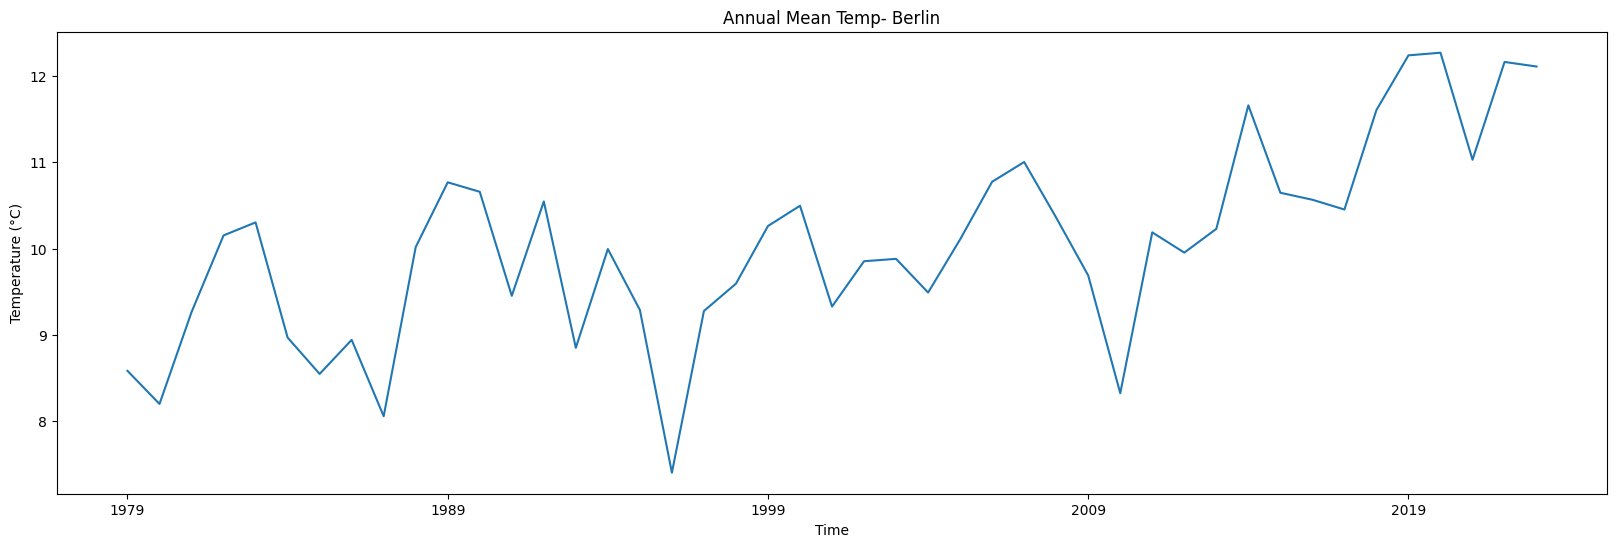

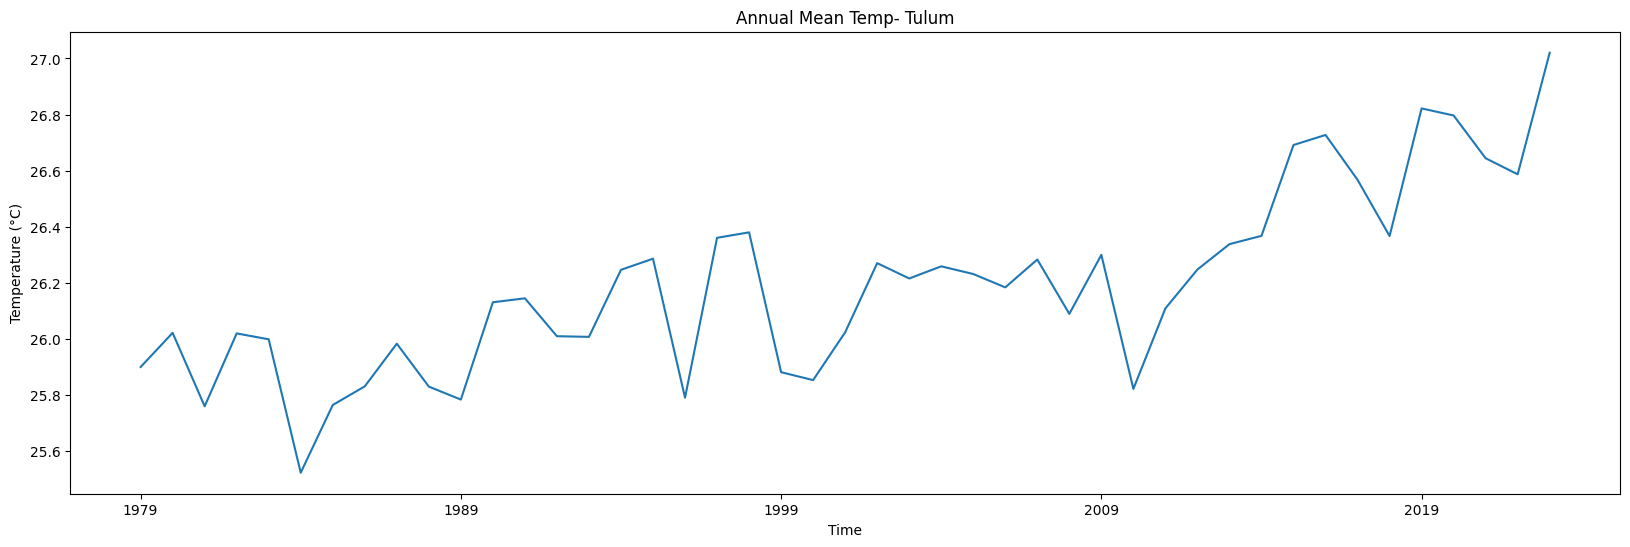

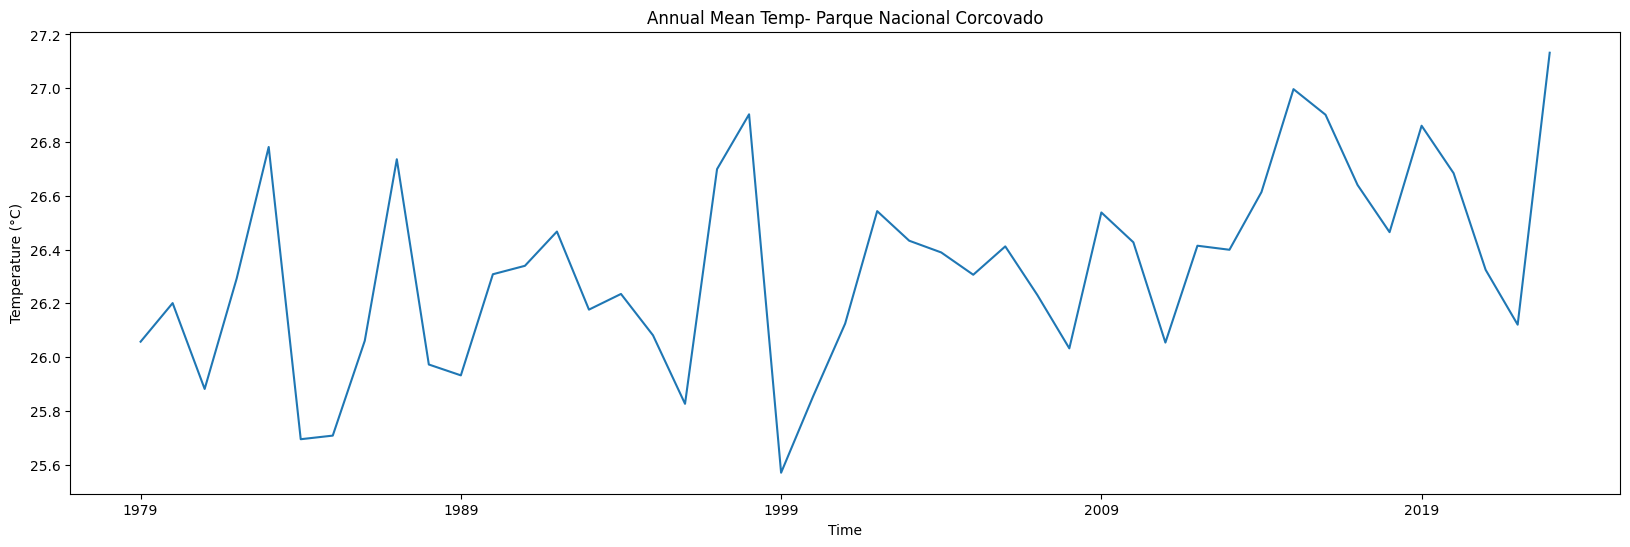

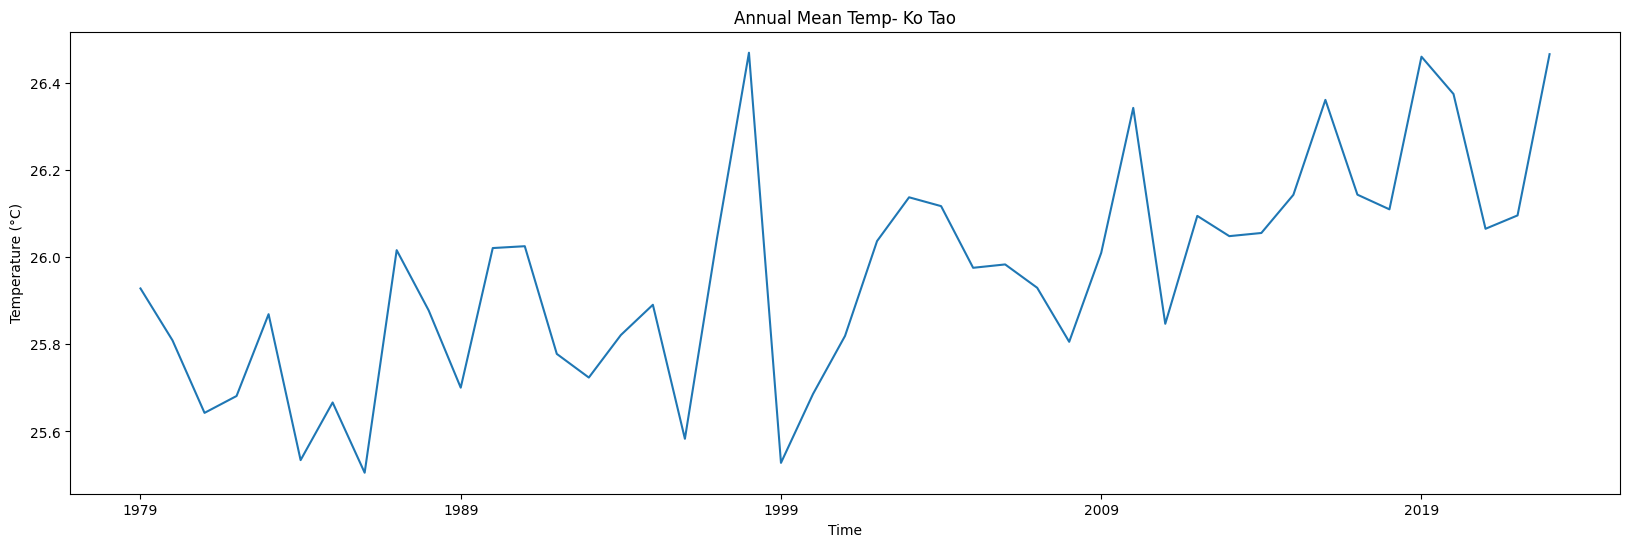

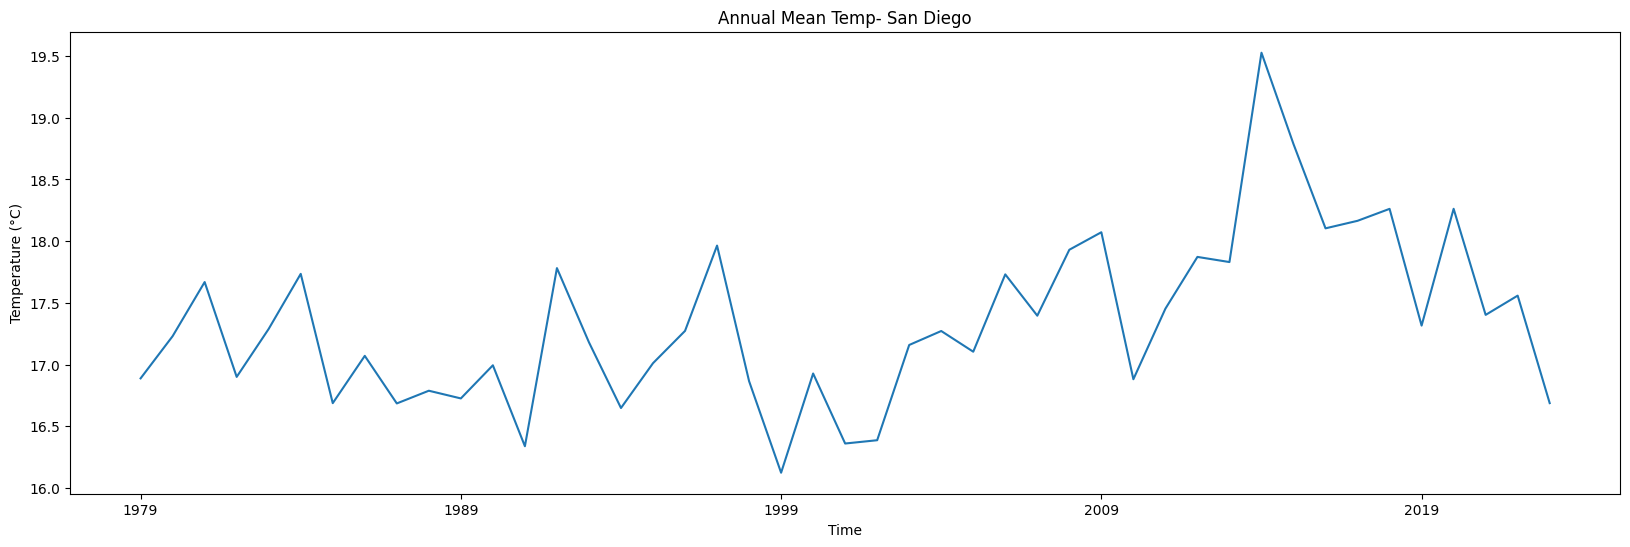

In [136]:
# Plot the annual mean temperatures
filtered_city_dfs = [filtered_weather_history_berlin, filtered_weather_history_tulum, filtered_weather_history_corcovado, filtered_weather_history_kotao, filtered_weather_history_sandiego]

def plot_medium_temp(df, city_name):
    df['main.temp'].groupby(df['Y']).mean().plot(figsize=(20, 6), title=f'Annual Mean Temp- {city_name}')
    plt.xlabel('Time')
    plt.ylabel('Temperature (°C)')
    plt.show()

for city_name, df in zip(['Berlin', 'Tulum', 'Parque Nacional Corcovado', 'Ko Tao', 'San Diego'], filtered_city_dfs):
    plot_medium_temp(df, city_name)

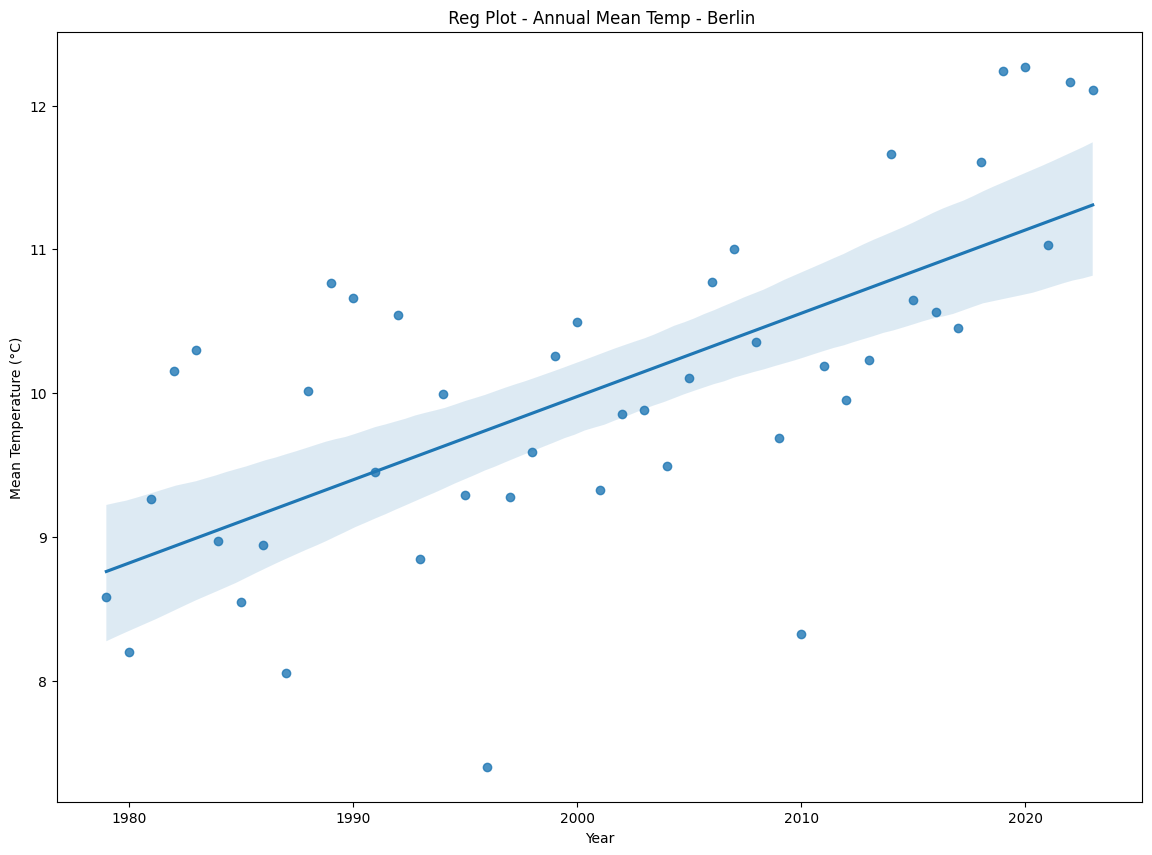

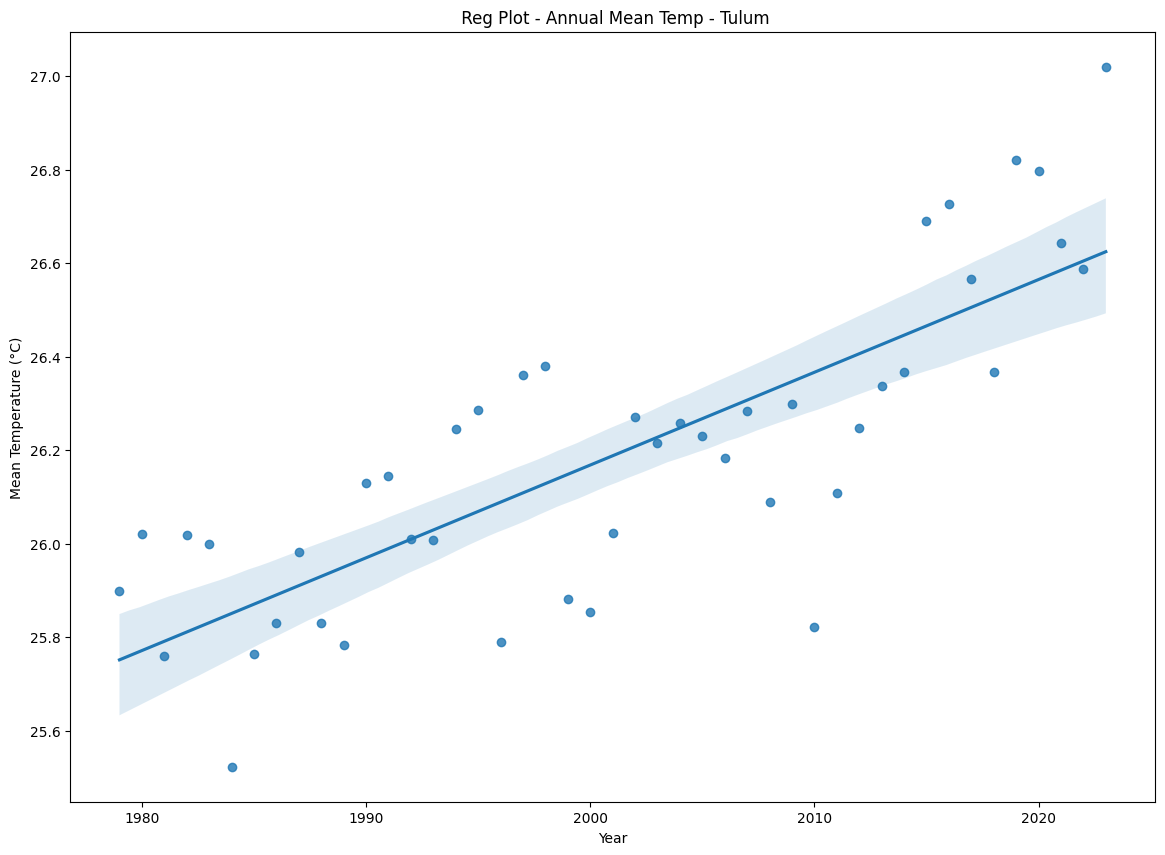

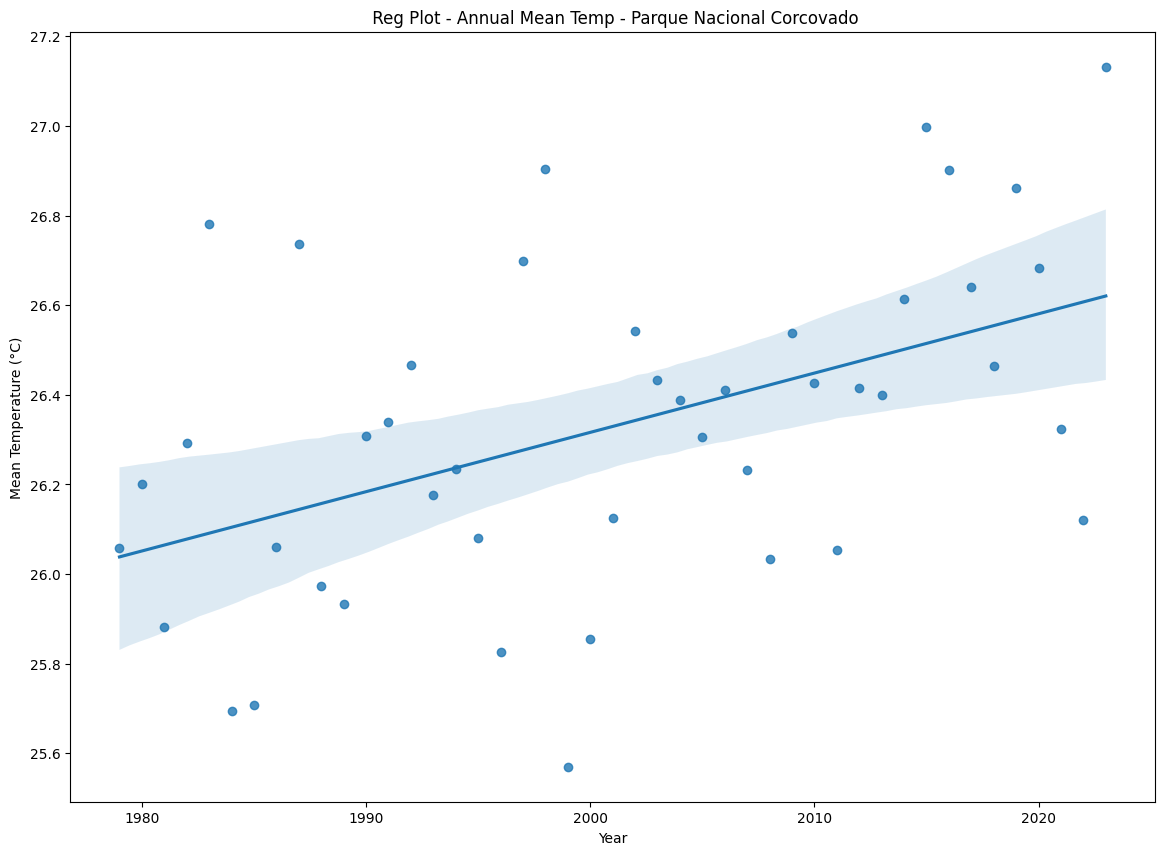

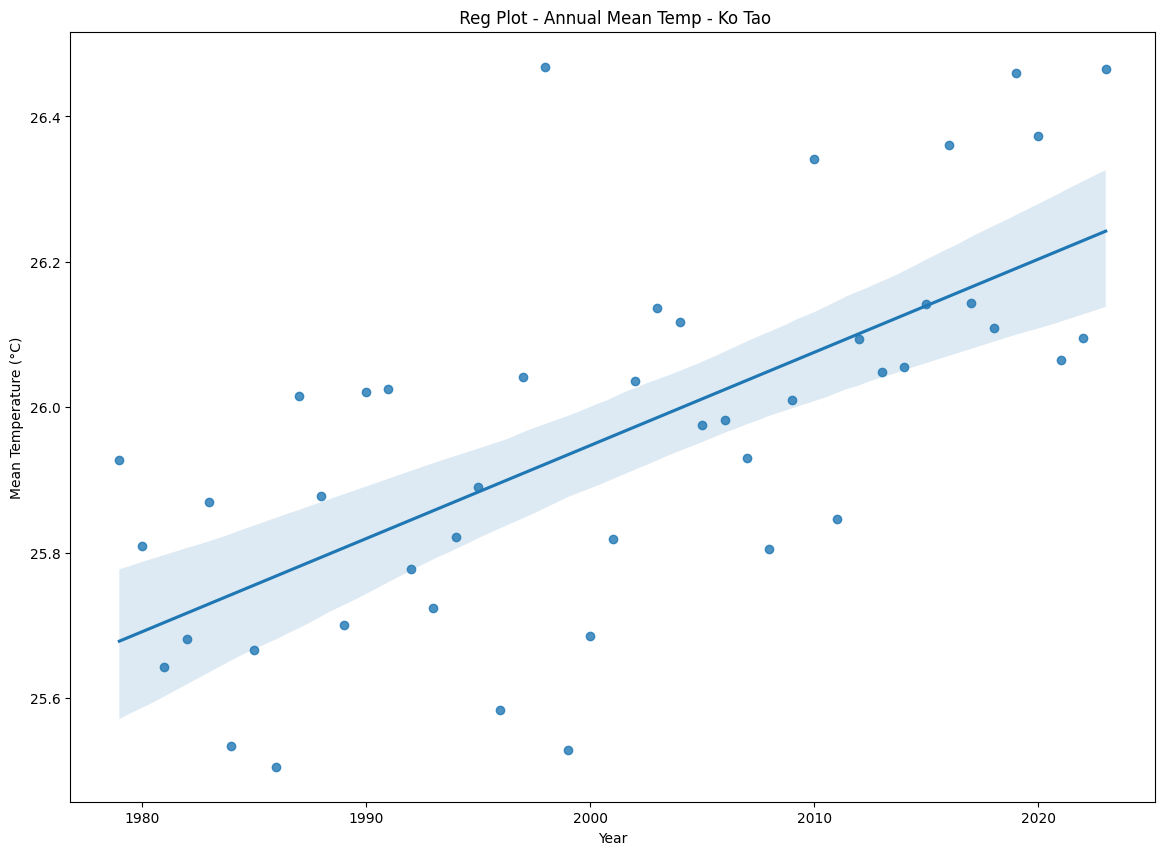

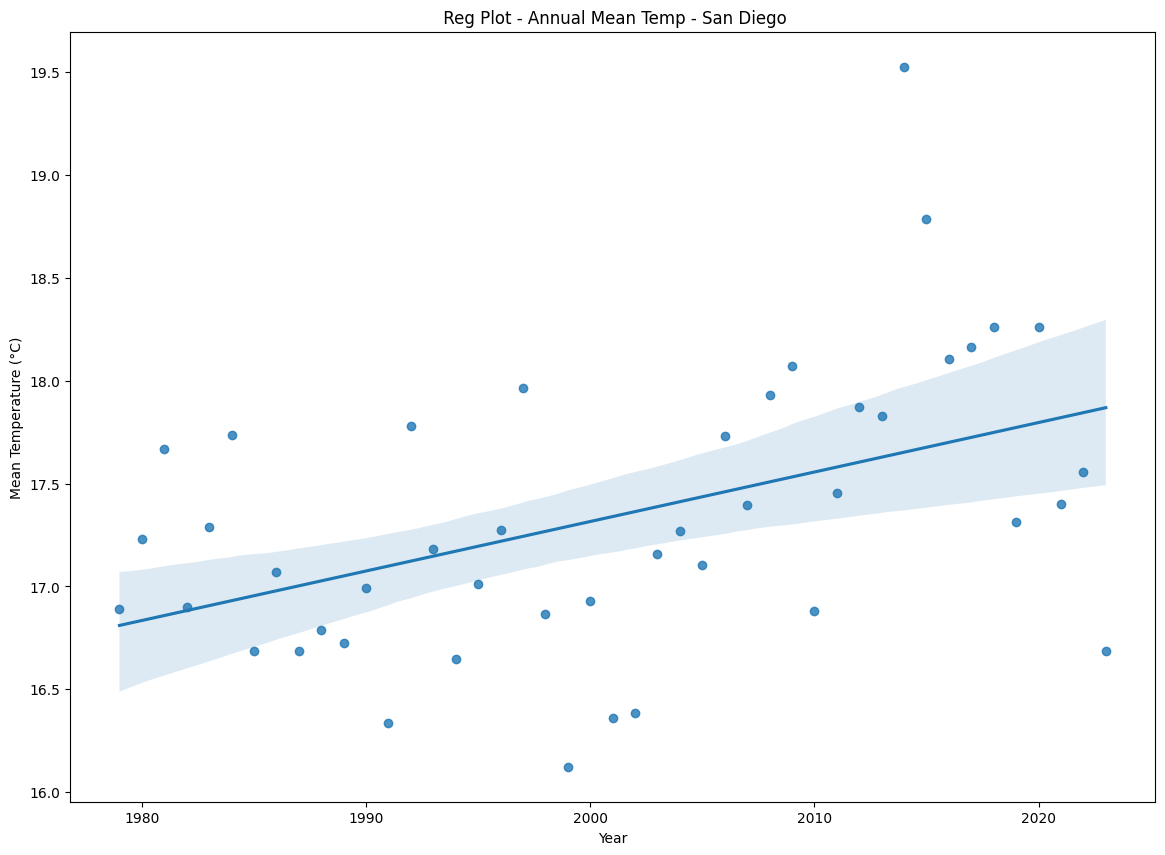

In [143]:
# Regression plot of annual mean temperatures
filtered_city_dfs = [filtered_weather_history_berlin, filtered_weather_history_tulum, filtered_weather_history_corcovado, filtered_weather_history_kotao, filtered_weather_history_sandiego]

def regplot_temp(df, city_name):
    
    fig = sns.regplot(x=df['Y'].unique().astype(int), y=df['main.temp'].groupby(df['Y']).mean().astype(float))
    fig.figure.set_size_inches(14, 10)
    plt.xlabel("Year")
    plt.ylabel("Mean Temperature (°C)")
    plt.title(f' Reg Plot - Annual Mean Temp - {city_name}') 
    plt.show(fig)

for city_name, df in zip(['Berlin', 'Tulum', 'Parque Nacional Corcovado', 'Ko Tao', 'San Diego'], filtered_city_dfs):
    regplot_temp(df, city_name)

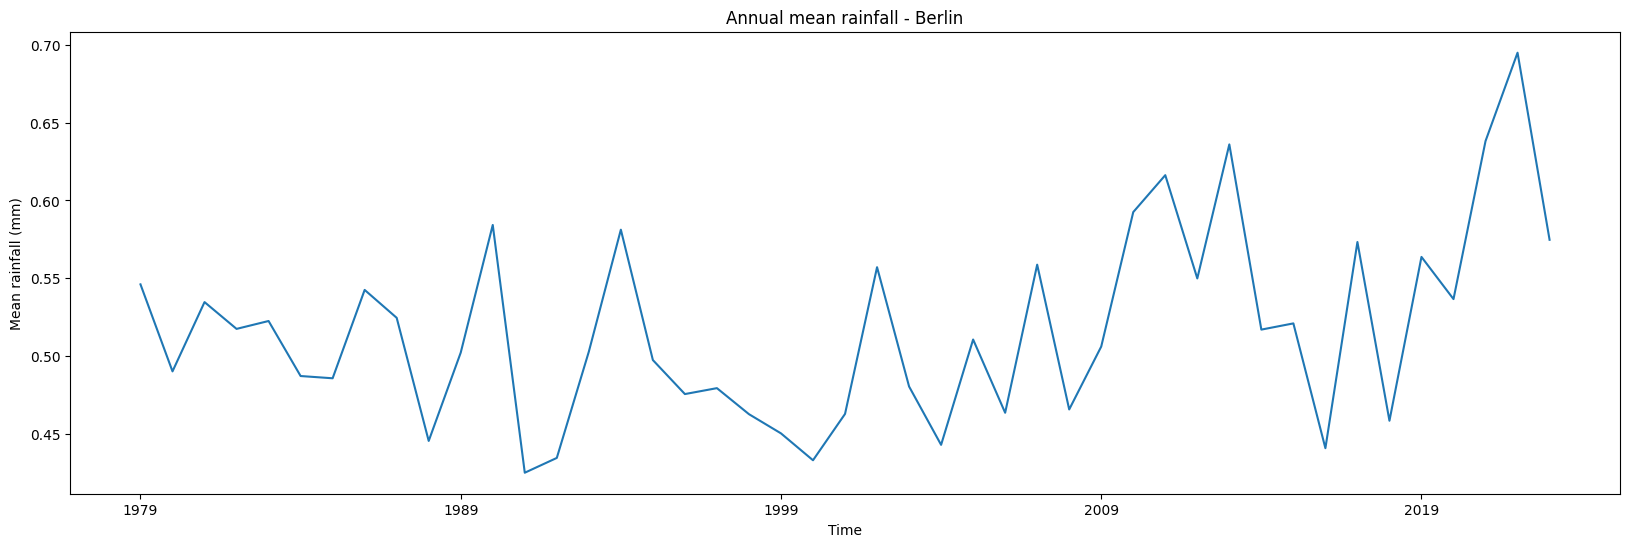

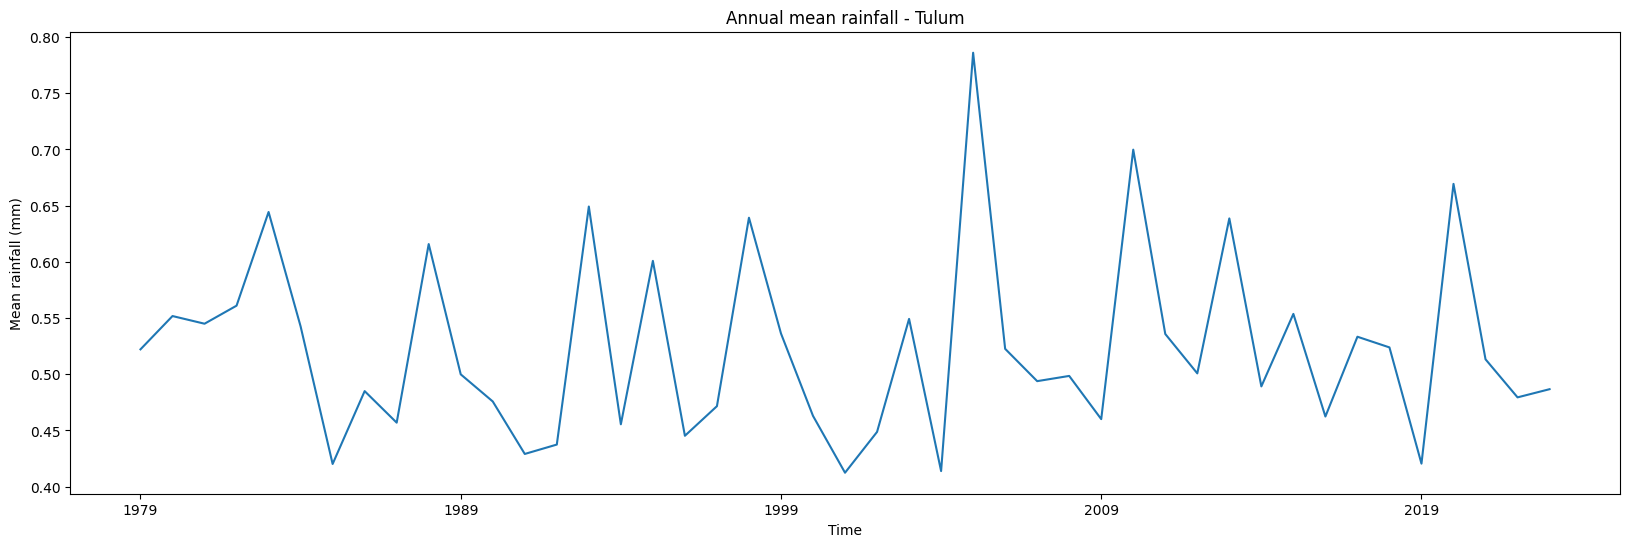

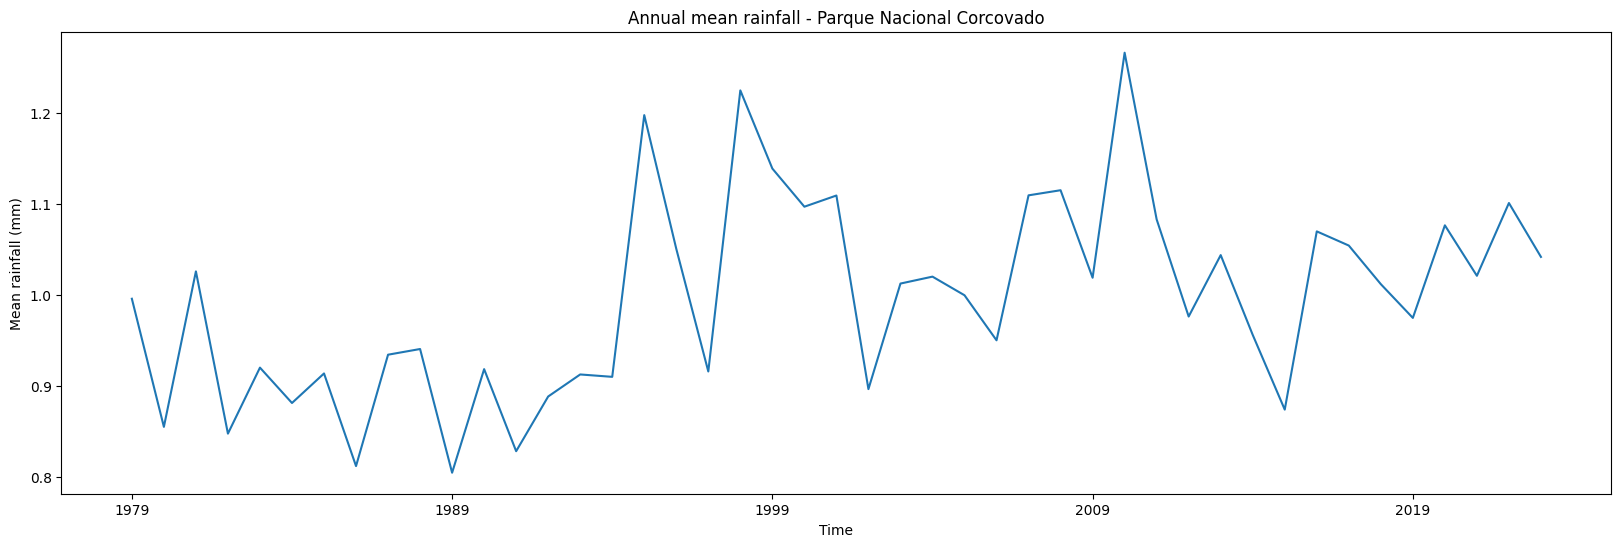

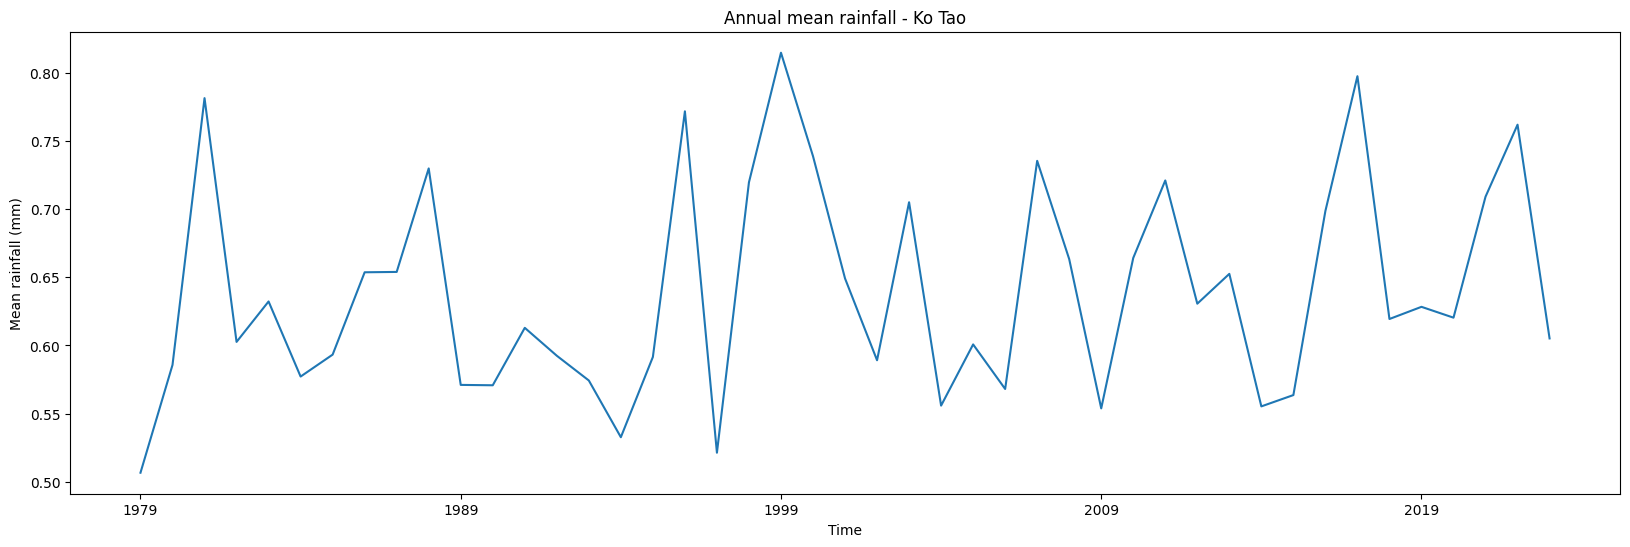

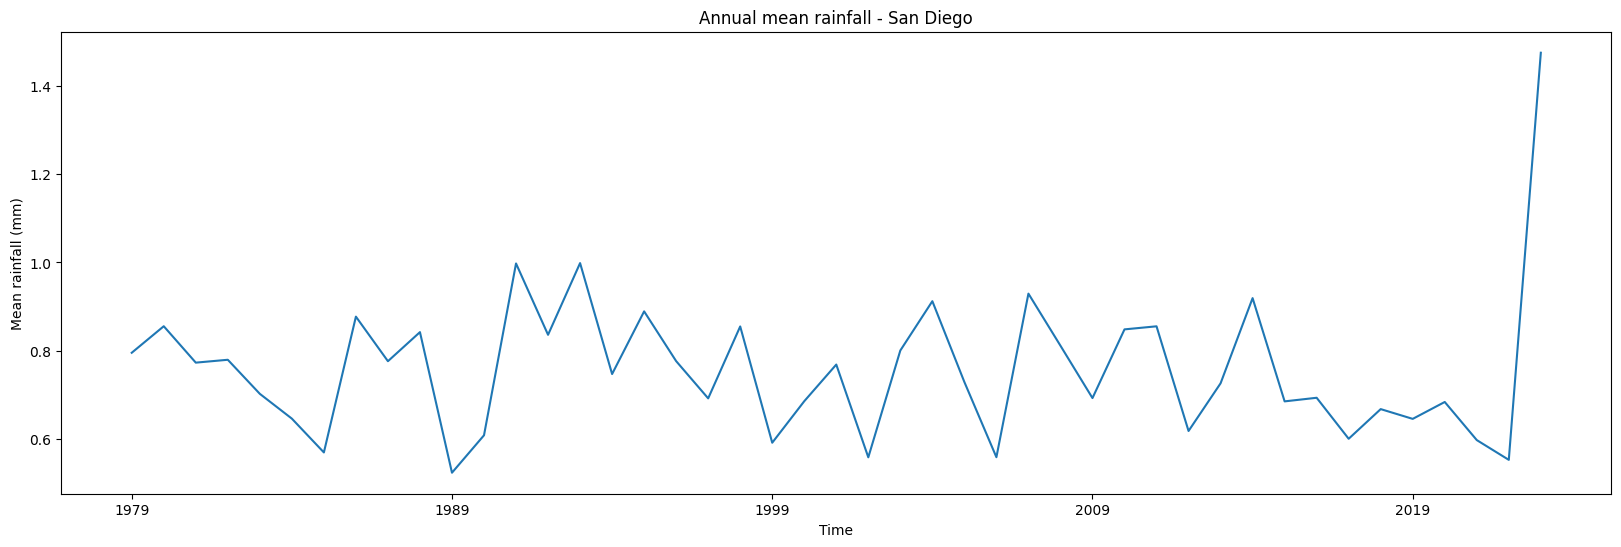

In [138]:
# Plot the annual mean rainfall
def plot_medium_temp(df, city_name):
    df['rain.1h'].groupby(df['Y']).mean().plot(figsize=(14, 10), title=f'Annual mean rainfall - {city_name}')
    plt.xlabel('Time')
    plt.ylabel('Mean rainfall (mm)')
    plt.show()

for city_name, df in zip(['Berlin', 'Tulum', 'Parque Nacional Corcovado', 'Ko Tao', 'San Diego'], filtered_city_dfs):
    plot_medium_temp(df, city_name)

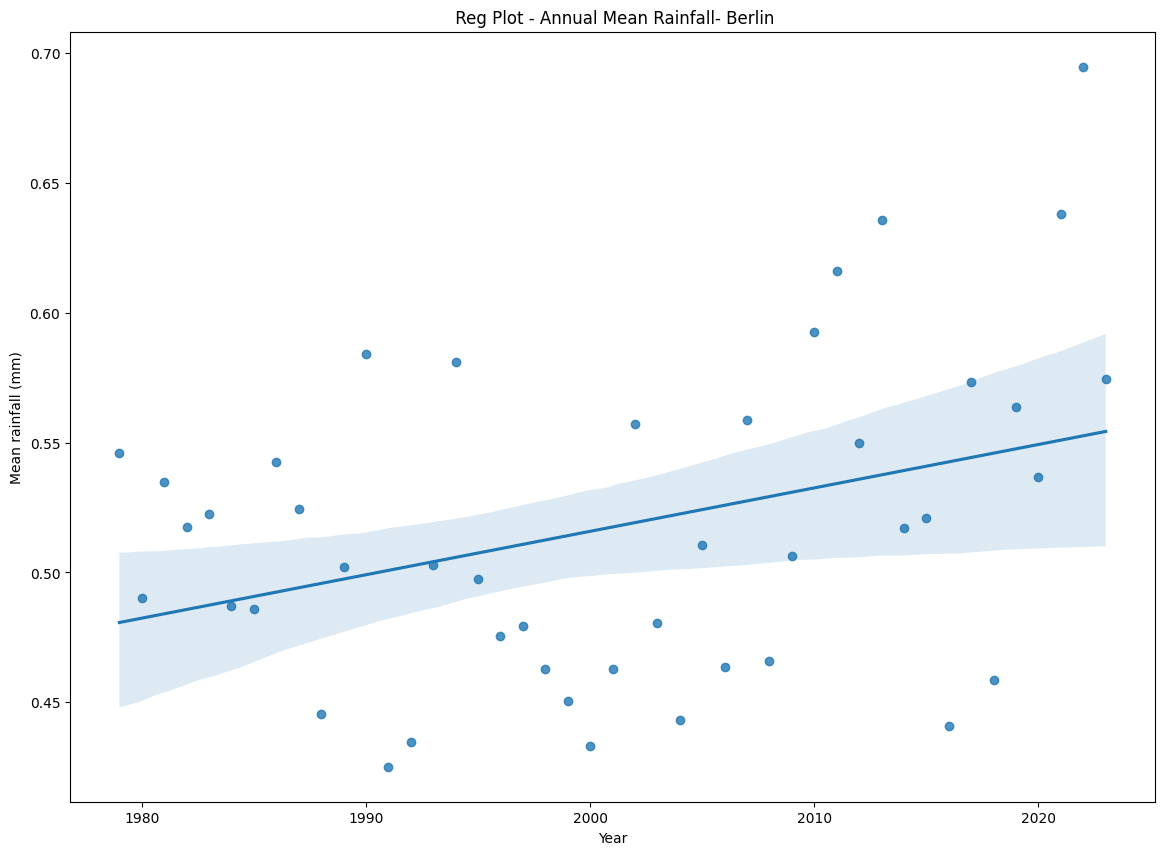

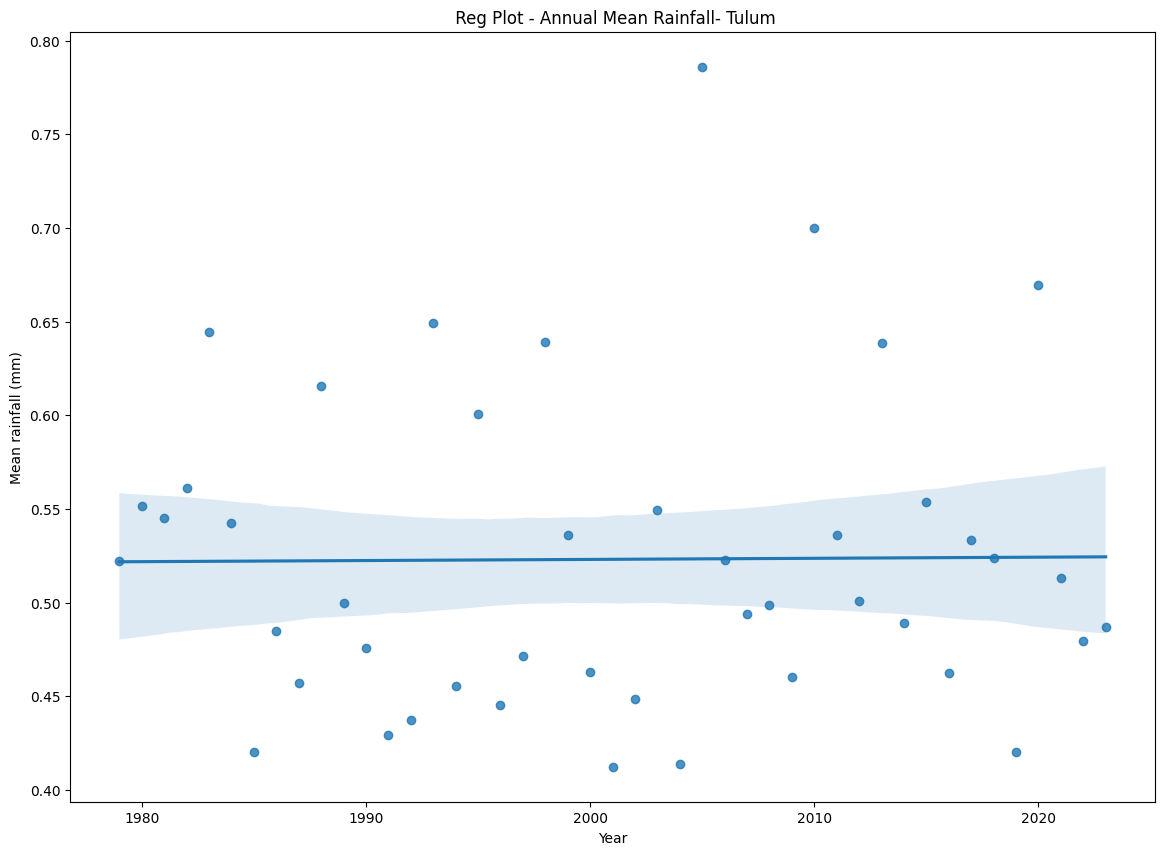

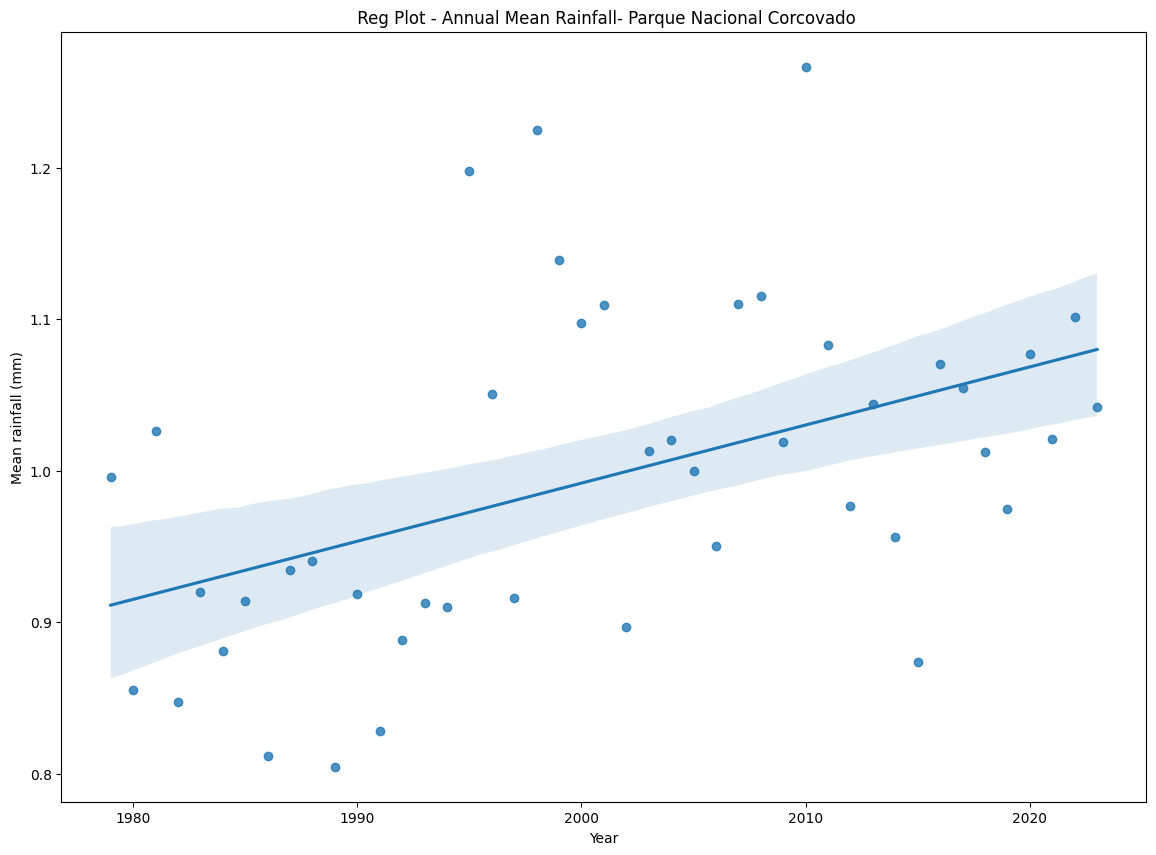

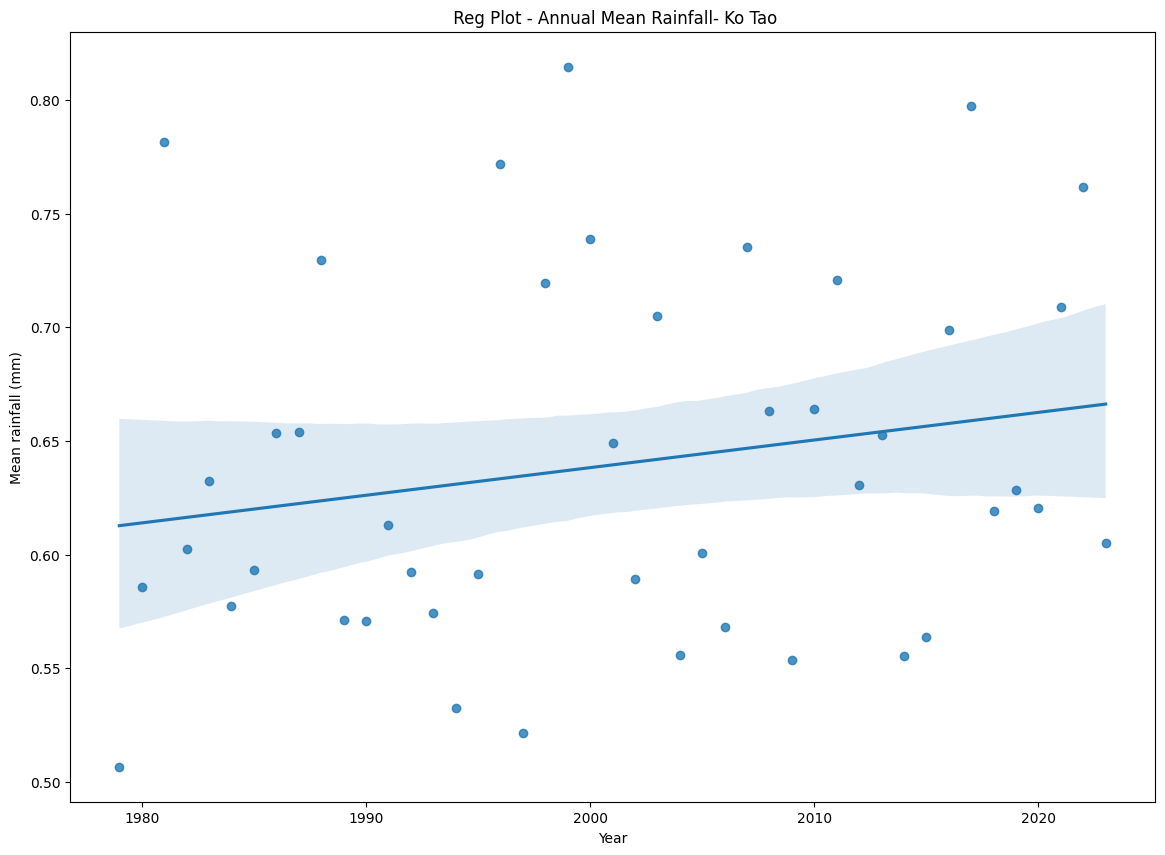

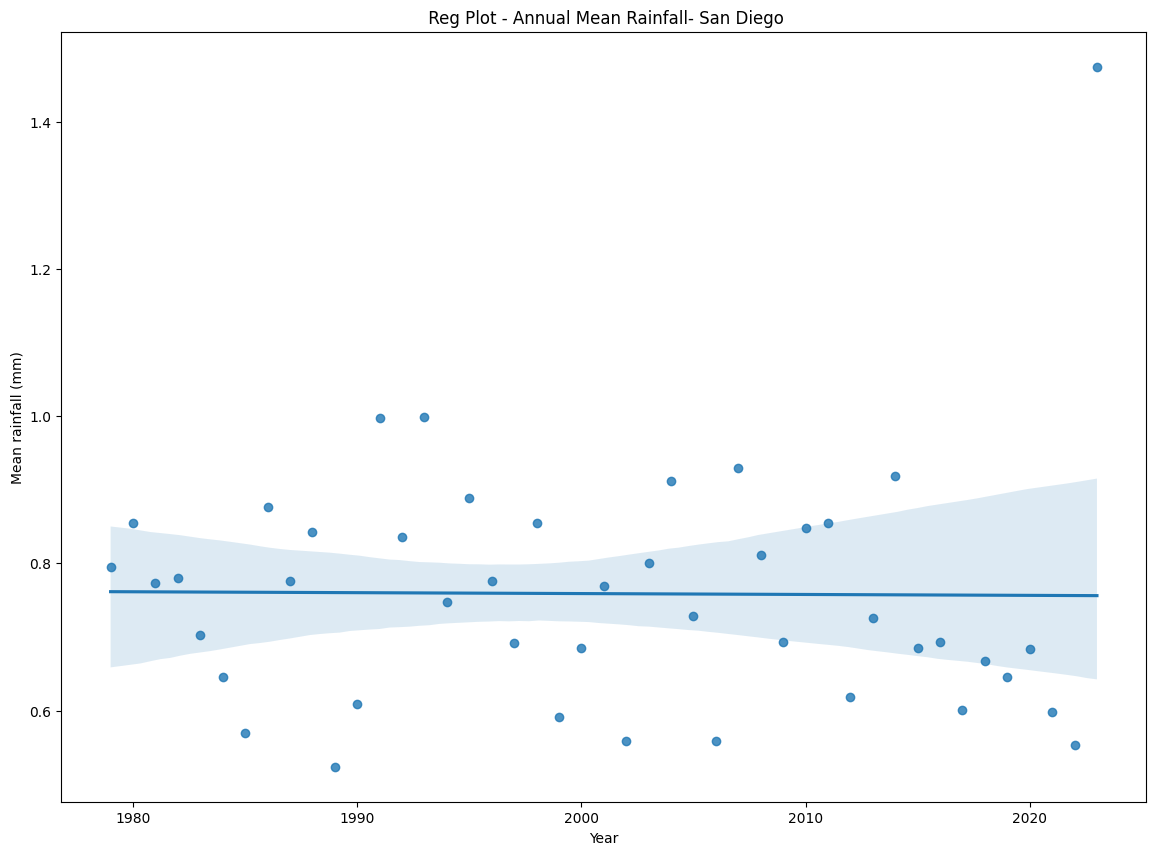

In [142]:
# Regression plot of annual mean rainfall
filtered_city_dfs = [filtered_weather_history_berlin, filtered_weather_history_tulum, filtered_weather_history_corcovado, filtered_weather_history_kotao, filtered_weather_history_sandiego]

def regplot_temp(df, city_name):
    
    fig = sns.regplot(x=df['Y'].unique().astype(int), y=df['rain.1h'].groupby(df['Y']).mean().astype(float))
    fig.figure.set_size_inches(14, 10)
    plt.xlabel("Year")
    plt.ylabel("Mean rainfall (mm)")
    plt.title(f' Reg Plot - Annual Mean Rainfall- {city_name}') 
    plt.show(fig)

for city_name, df in zip(['Berlin', 'Tulum', 'Parque Nacional Corcovado', 'Ko Tao', 'San Diego'], filtered_city_dfs):
    regplot_temp(df, city_name)